<a href="https://colab.research.google.com/github/nickchak21/QuarkGluonClassifiers/blob/master/Executable_Colab_Notebooks/EFN/EFN_example_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing the energyflow and h5py packages in the Colab environment

In [1]:
!pip install energyflow
!pip install h5py

     |████████████████████████████████| 696kB 6.4MB/s 
     |████████████████████████████████| 2.9MB 27.9MB/s 
  Found existing installation: h5py 2.8.0
    Uninstalling h5py-2.8.0:
      Successfully uninstalled h5py-2.8.0


Checking the version of Python (should be Python 3.6)

In [2]:
!python --version

Python 3.6.9


Installing POT (Python Optimal Transport) package

In [3]:
!pip install POT

     |████████████████████████████████| 307kB 6.5MB/s 


In [0]:
%tensorflow_version 1.x #specifies that we want to use TensorFlow 1 (the default on Colab is going to switch soon)

The following code runs a quark gluon classifier using a EFN (Energy Flow Network) architecture. The input jets are detector-simulated. The AUC tops out at around 0.76. This model can be trained/validated/tested on more data (up to 500,000 jets in Colab), but we use 220,000 jets total so we can compare it directly to the CNN. Here, we use 165,000 jets to train, 22,000 jets to validate, and and 33,000 jets to test.

Using TensorFlow backend.


Loaded quark and gluon jets
Finished preprocessing
Done train/val/test split
Model summary:





Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
phats_input (InputLayer)        (None, None, 2)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    300         phats_input[0][0]                
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_1[0][0]           

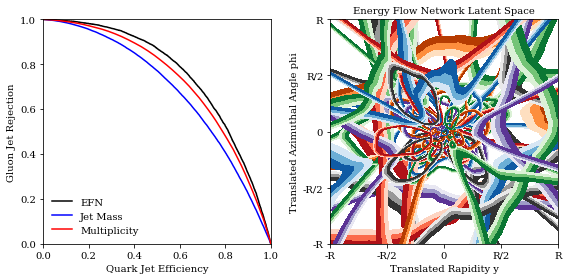

In [4]:
# standard library imports
from __future__ import absolute_import, division, print_function

# standard numerical library imports
import numpy as np

# energyflow imports
import energyflow as ef
from energyflow.archs import EFN
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, to_categorical

# attempt to import sklearn
try:
    from sklearn.metrics import roc_auc_score, roc_curve
except:
    print('please install scikit-learn in order to make ROC curves')
    roc_curve = False

# attempt to import matplotlib
try:
    import matplotlib.pyplot as plt
except:
    print('please install matplotlib in order to make plots')
    plt = False

#load data
specs = ['375 <= corr_jet_pts <= 425', 'abs_jet_eta < 1.9', 'quality >= 2']
amount = 0.1
sim = ef.mod.load(*specs, dataset='sim', amount=amount)

jet_array = np.zeros((294363,160,6))
for i in range(294363):
    for j in range(160):
        for k in range(6):
            try:
                jet_array[i,j,k] = sim.particles[i][j][k]
            except IndexError:
                jet_array[i,j,k] = 0

labels = []
for i in range(len(sim.hard_pids)):
    if sim.hard_pids[i] == 21:
        labels.append(0)
    else:
        labels.append(1)
label_array = np.asarray(labels)

################################### SETTINGS ##################################
# the commented values correspond to those in 1810.05165
###############################################################################

# data controls, can go up to 2000000 total for full dataset
train, val, test = 165000, 22000, 33000
# train, val, test = 1000000, 200000, 200000

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
# Phi_sizes, F_sizes = (100, 100, 256), (100, 100, 100)

# network training parameters
num_epoch = 25
batch_size = 500

X = jet_array[:220000,:,:4]
y = label_array[:220000]

# ignore pid information
X = X[:,:,:3]

# convert labels to categorical
Y = to_categorical(y, num_classes=2)

print('Loaded quark and gluon jets')

# preprocess by centering jets and normalizing pts
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

print('Finished preprocessing')

# do train/val/test split 
(z_train, z_val, z_test, 
 p_train, p_val, p_test,
 Y_train, Y_val, Y_test) = data_split(X[:,:,0], X[:,:,1:], Y, val=val, test=test)

print('Done train/val/test split')
print('Model summary:')

# build architecture
efn = EFN(input_dim=2, Phi_sizes=Phi_sizes, F_sizes=F_sizes)

# train model
efn.fit([z_train, p_train], Y_train,
          epochs=num_epoch,
          batch_size=batch_size,
          validation_data=([z_val, p_val], Y_val),
          verbose=1)

# get predictions on test data
preds = efn.predict([z_test, p_test], batch_size=1000)

# get ROC curve if we have sklearn
if roc_curve:
    efn_fp, efn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

    # get area under the ROC curve
    auc = roc_auc_score(Y_test[:,1], preds[:,1])
    print()
    print('EFN AUC:', auc)
    print()

    # make ROC curve and filter plot if we have matplotlib
    if plt:

        # some nicer plot settings 
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['figure.autolayout'] = True

        fig, axes = plt.subplots(1, 2, figsize=(8,4))

        ######################### ROC Curve Plot #########################

        # get multiplicity and mass for comparison
        masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
        mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
        mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
        mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

        # plot the ROC curves
        axes[0].plot(efn_tp, 1-efn_fp, '-', color='black', label='EFN')
        axes[0].plot(mass_tp, 1-mass_fp, '-', color='blue', label='Jet Mass')
        axes[0].plot(mult_tp, 1-mult_fp, '-', color='red', label='Multiplicity')

        # axes labels
        axes[0].set_xlabel('Quark Jet Efficiency')
        axes[0].set_ylabel('Gluon Jet Rejection')

        # axes limits
        axes[0].set_xlim(0, 1)
        axes[0].set_ylim(0, 1)

        # make legend and show plot
        axes[0].legend(loc='lower left', frameon=False)

        ######################### Filter Plot #########################

        # plot settings
        R, n = 0.4, 100
        colors = ['Reds', 'Oranges', 'Greens', 'Blues', 'Purples', 'Greys']
        grads = np.linspace(0.45, 0.55, 4)

        # evaluate filters
        X, Y, Z = efn.eval_filters(R, n=n)

        # plot filters
        for i,z in enumerate(Z):
            axes[1].contourf(X, Y, z/np.max(z), grads, cmap=colors[i%len(colors)])
        
        axes[1].set_xticks(np.linspace(-R, R, 5))
        axes[1].set_yticks(np.linspace(-R, R, 5))
        axes[1].set_xticklabels(['-R', '-R/2', '0', 'R/2', 'R'])
        axes[1].set_yticklabels(['-R', '-R/2', '0', 'R/2', 'R'])
        axes[1].set_xlabel('Translated Rapidity y')
        axes[1].set_ylabel('Translated Azimuthal Angle phi')
        axes[1].set_title('Energy Flow Network Latent Space', fontdict={'fontsize': 10})
    
        plt.show()